In [1]:
!pip install pandas numpy matplotlib seaborn dash plotly dash_daq dash_bootstrap_components

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, html, dash_table, dcc, Input, Output, callback
import dash
import dash_daq as daq
import dash_bootstrap_components as dbc
import plotly.express as px

warnings.filterwarnings('ignore')

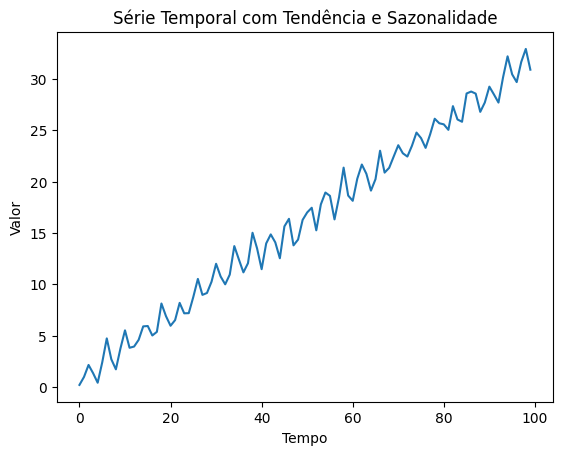

In [3]:
def gerar_serie_temporal(tendencia, amplitude_sazonal, periodo_sazonal, n, ruido = 0):
    # Gere uma tendência linear
    t = np.arange(start=3, stop=n+3, step=1)
    tendencia_linear = tendencia * t

    # Gere uma componente sazonal senoidal
    sazonalidade = amplitude_sazonal * np.sin(2 * np.pi * t / periodo_sazonal)

    # Gere ruído aleatório
    ruido = np.random.normal(0, ruido, n)

    # Série temporal final
    serie_temporal = tendencia_linear + sazonalidade + ruido

    return serie_temporal

# Visualize a série temporal
plt.plot(gerar_serie_temporal(0.31, 1.3, 4, 100, 0.5))
plt.title("Série Temporal com Tendência e Sazonalidade")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

In [4]:
## tendencia, amplitude_sazonal, periodo_sazonal, n, ruido = 0

df = pd.DataFrame()
df['data'] = pd.date_range(start='1/1/2022', periods=100, freq='W')
#df['data'] = df['data'].astype('datetime64')
df['num_conteudos_criados_mes'] = gerar_serie_temporal(0.4, 0.7, 4, 100)
df['num_utilizacao_material_mês'] = gerar_serie_temporal(0.18, 3.27, 2.27, 100, 0.12)
df['nps_recomendacoes'] = np.logspace(8, 9, num=100) + np.random.normal(0, 0.2, 100)
df['rendimento_inicial_academico'] = np.random.binomial(60, 0.5, size=100)
df['media_rendimento_academico'] = np.random.binomial(100, 0.5, size=100)
df['tempo_plataforma'] = np.random.normal(4, 2, size=100)
df['evolucao_nota_plataformas'] = 100 - np.random.exponential(scale=3, size=100)
df['volume_clientes_ativos'] = gerar_serie_temporal(0.9, 0, 0.2, 100, 0.3) *1000
df['novos_clientes_mes'] = (df['volume_clientes_ativos'] - df['volume_clientes_ativos'].shift(1)) * 1.1
df.dropna(inplace=True)
df['margem_lucro'] = ((df['novos_clientes_mes'] * 0.21) / 100) + 25
df['crescimento_receitas'] = df['margem_lucro'] * df['novos_clientes_mes']
df['ticket_medio'] = np.random.lognormal(4, 0.5, len(df['crescimento_receitas']))

In [5]:
# df['rendimento_inicial_academico'].hist()
# plt.title("Histograma do Rendimento Acadêmico Inicial")
# plt.xlabel("Média de Rendimento Acadêmico")
# plt.ylabel("Frequência")
# plt.show()
# df['media_rendimento_academico'].hist()
# plt.title("Histograma da Média de Rendimento Acadêmico")
# plt.xlabel("Média de Rendimento Acadêmico")
# plt.ylabel("Frequência")
# plt.show()

num_conteudos_criados_mes


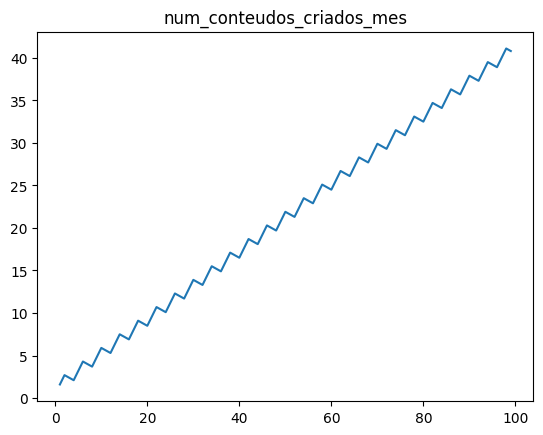

num_utilizacao_material_mês


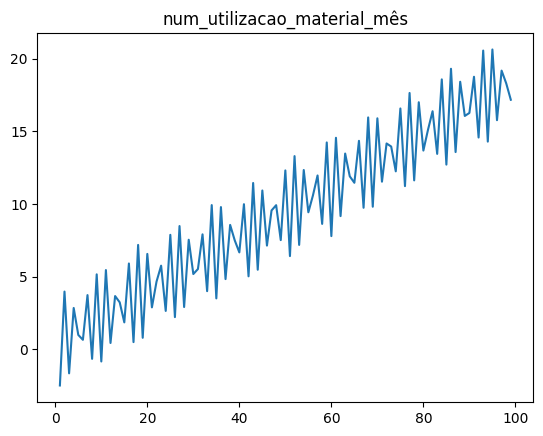

nps_recomendacoes


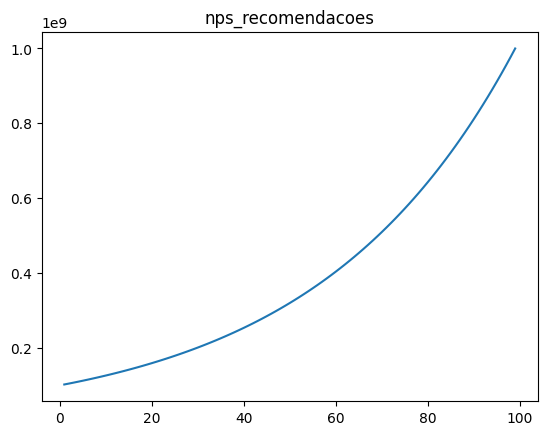

rendimento_inicial_academico


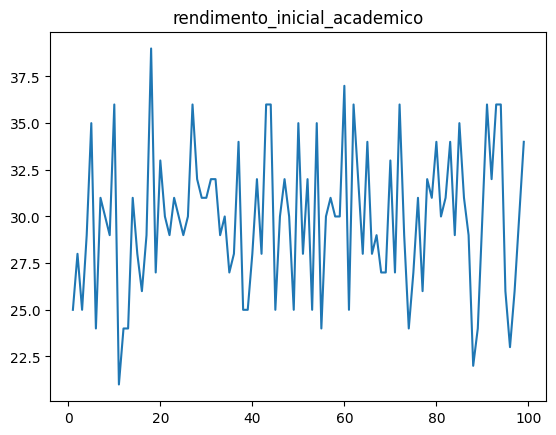

media_rendimento_academico


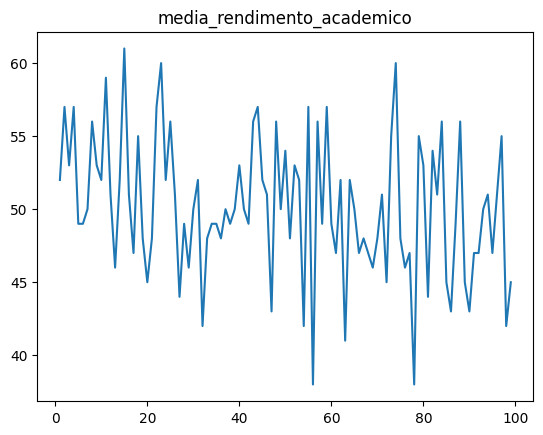

tempo_plataforma


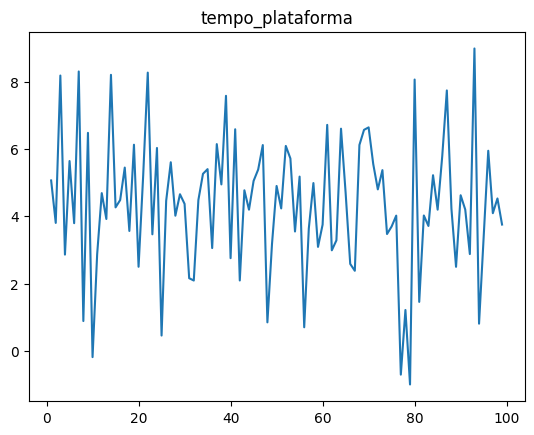

evolucao_nota_plataformas


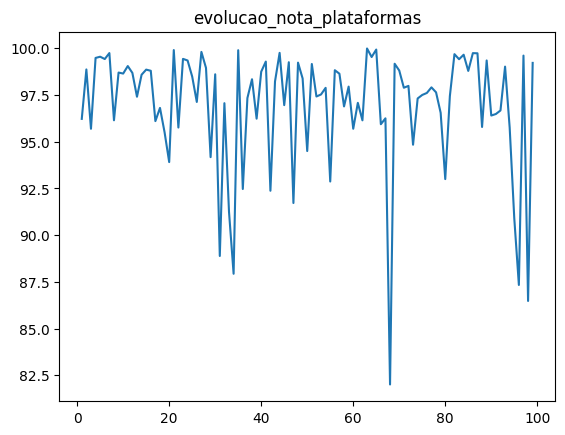

volume_clientes_ativos


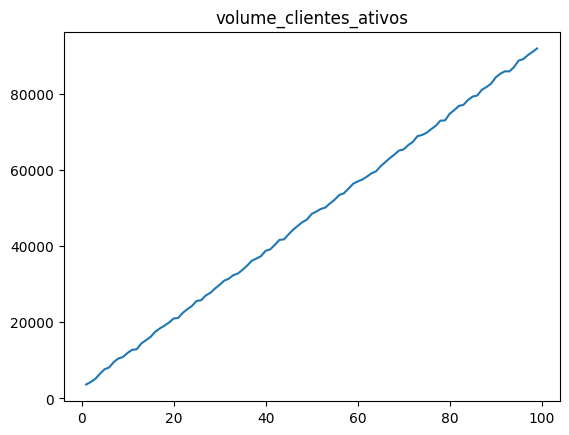

novos_clientes_mes


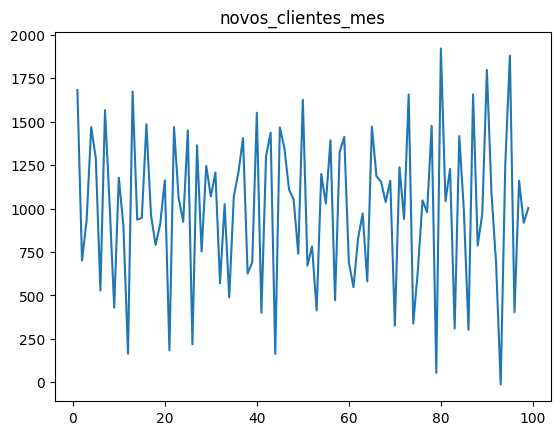

margem_lucro


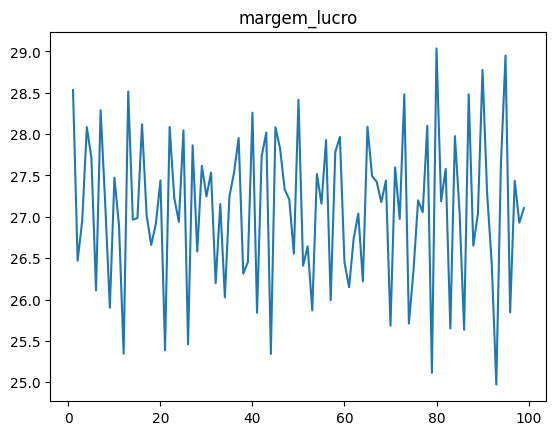

crescimento_receitas


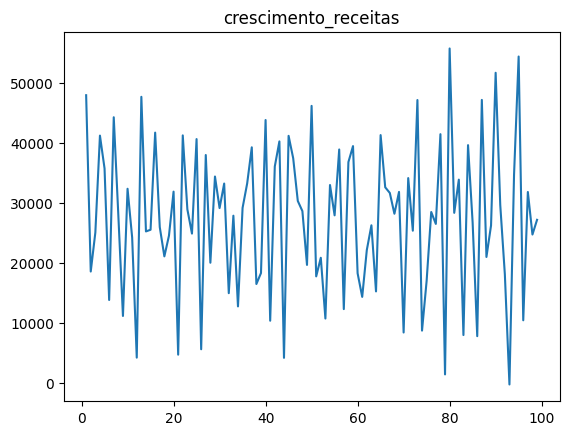

ticket_medio


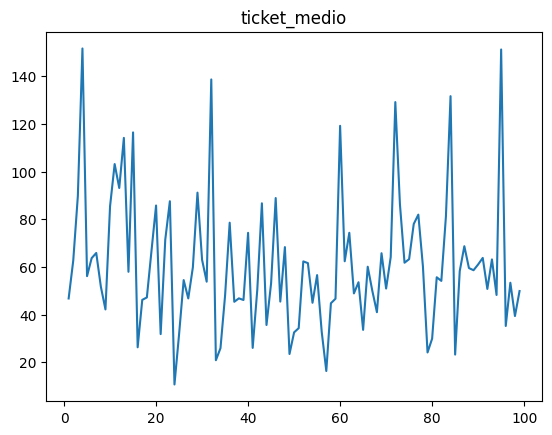

In [6]:
 
for coluna in df.columns:
    if coluna == 'data':
        continue
    print(f'{coluna}')
    df[coluna].describe()
    df[coluna].plot(title=coluna)
    plt.show()
    

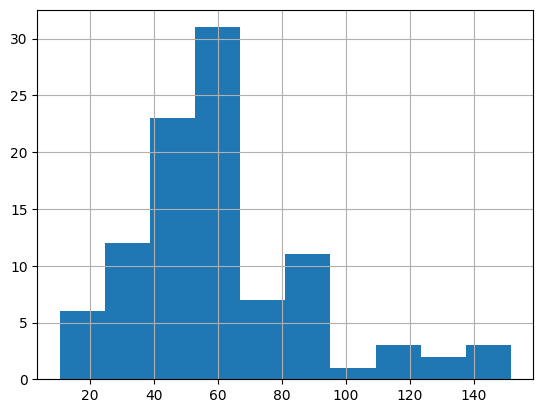

In [7]:
df['ticket_medio'].hist()
plt.show()

In [8]:
print(df.columns)

Index(['data', 'num_conteudos_criados_mes', 'num_utilizacao_material_mês',
       'nps_recomendacoes', 'rendimento_inicial_academico',
       'media_rendimento_academico', 'tempo_plataforma',
       'evolucao_nota_plataformas', 'volume_clientes_ativos',
       'novos_clientes_mes', 'margem_lucro', 'crescimento_receitas',
       'ticket_medio'],
      dtype='object')


In [12]:
# Layout do painel
gauge = html.Div(
    [
        daq.Gauge(
            label="Tempo na plataforma (em horas)",
            scale={"start": 0, "interval": 1, "labelInterval": 1},
            id="gauge",
            min=0,
            max=8,
            value=df['tempo_plataforma'].mean(),
        ),
    ],
    className="d-grid gap-2",
)

gauge2 = html.Div(
    [
        daq.Gauge(
            label="Margem de lucro (%)",
            scale={"start": 10, "interval": 2, "labelInterval": 2},
            id="gauge2",
            min=10,
            max=30,
            value=df['margem_lucro'].mean(),
        ),
    ],
    className="d-grid gap-2",
)

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Definindo as cores
colors = {
    'background': '#f9f9f9',
    'text': '#333333',
    'primary': '#1f77b4',
    'secondary': '#2ca02c'
}

app.layout = html.Div([
    html.H1("iConcurso", style={'textAlign': 'center', 'marginBottom': '30px', 'color': colors['text']}),
    
    dbc.Container([
        # Primeira linha com os gauges
        dbc.Row(
            [
                dbc.Col(gauge, md=6),
                dbc.Col(gauge2, md=6)
            ],
            align="center",
            style={'marginBottom': '30px'}
        ),
        
        # Abas para organizar os gráficos
        dbc.Tabs([
            dbc.Tab(label='Conteúdos e Utilizações', tab_id='tab-1'),
            dbc.Tab(label='Rendimento Acadêmico', tab_id='tab-2'),
            dbc.Tab(label='Plataformas e Clientes', tab_id='tab-3'),
            dbc.Tab(label='Receitas e Lucros', tab_id='tab-4'),
        ], id='tabs', active_tab='tab-1'),
        
        # Conteúdo das abas
        html.Div(id='tab-content')
    ])
], style={'backgroundColor': colors['background']})

@app.callback(
    dash.dependencies.Output('tab-content', 'children'),
    [dash.dependencies.Input('tabs', 'active_tab')]
)
def render_tab_content(active_tab):
    if active_tab == 'tab-1':
        return dbc.Container([
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-conteudos',
                    figure=px.bar(df, x='data', y='num_conteudos_criados_mes', title='Número de Conteúdos Criados por Mês')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6),
                dbc.Col(dcc.Graph(
                    id='grafico-utilizacao',
                    figure=px.bar(df, x='data', y='num_utilizacao_material_mês', title='Número de Utilizações de Material por Mês')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['secondary'], font_color=colors['text'])
                ), md=6)
            ])
        ])
    elif active_tab == 'tab-2':
        return dbc.Container([
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-rendimento-inicial',
                    figure=px.histogram(df, x='rendimento_inicial_academico', title='Rendimento Inicial Acadêmico')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6),
                dbc.Col(dcc.Graph(
                    id='grafico-rendimento_atual',
                    figure=px.histogram(df, x='media_rendimento_academico', title='Rendimento Acadêmico atual dos estudantes')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['secondary'], font_color=colors['text'])
                ), md=6)
            ]),
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-tempo_plataforma',
                    figure=px.histogram(df, x='tempo_plataforma', title='Tempo médio dos estudantes na plataforma (em horas)')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6)
            ])
        ])
    elif active_tab == 'tab-3':
        return dbc.Container([
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-evolucao_nota_plataformas',
                    figure=px.line(df, y='evolucao_nota_plataformas', x='data', title='Evolução da média da Nota do aplicativo nas Plataformas')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6),
                dbc.Col(dcc.Graph(
                    id='grafico-volume_clientes_ativos',
                    figure=px.line(df, y='volume_clientes_ativos', x='data', title='Volume de Clientes Ativos')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['secondary'], font_color=colors['text'])
                ), md=6)
            ]),
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-novos_clientes_mes',
                    figure=px.line(df, y='novos_clientes_mes', x='data', title='Número de Novos Clientes por Mês')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6)
            ])
        ])
    elif active_tab == 'tab-4':
        return dbc.Container([
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-margem_lucro',
                    figure=px.line(df, y='margem_lucro', x='data', title='Evolução da margem de Lucro (%)')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6),
                dbc.Col(dcc.Graph(
                    id='grafico-crescimento_receitas',
                    figure=px.line(df, y='crescimento_receitas', x='data', title='Crescimento das Receitas ($)')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['secondary'], font_color=colors['text'])
                ), md=6)
            ]),
            dbc.Row([
                dbc.Col(dcc.Graph(
                    id='grafico-ticket_medio',
                    figure=px.histogram(df, x='ticket_medio', title='Tempo médio até a aprovação do estudante')
                    .update_layout(plot_bgcolor=colors['background'], paper_bgcolor=colors['background'], title_font_color=colors['primary'], font_color=colors['text'])
                ), md=6)
            ])
        ])

if __name__ == '__main__':
    app.run(debug=True, port=7070, host='0.0.0.0')